In [1]:
import os
path = '/content/drive/Othercomputers/daniel_mac/Desktop/MIT/ml_approx/'

In [3]:
import math
import numpy as np
import pandas as pd
import torch
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_palette("husl", 12)
sns.set_context("paper")

from tqdm import tqdm
from numpy.linalg import norm, pinv
from sklearn.random_projection import (
    SparseRandomProjection,
    GaussianRandomProjection,
)
from scipy.linalg import hadamard

from decimal import Decimal, getcontext

In [16]:
def exact_sparse(A, c):
    x, y = np.unravel_index(np.argsort(np.abs(A), axis=None), A.shape)
    num_zero = math.ceil(A.size * c)
    new_A = np.array(A)
    new_A[x[:num_zero], y[:num_zero]] = 0
    return new_A

def weighted_rand_sparse(A, c, p):
    new_A = np.array(A)
    comp = np.power(np.abs(A), p) / np.random.exponential(1, A.shape)
    x, y = np.unravel_index(np.argsort(comp, axis=None), A.shape)
    num_zero = math.ceil(A.size * c)
    new_A[x[:num_zero], y[:num_zero]] = 0
    return new_A

def low_rank(A, c):
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    rank = math.floor((1 - c) * S.shape[0])
    S[rank:] = 0
    return U @ np.diag(S) @ Vh

def gaussian_rand_proj(A, c):
    if c == 1:
        return np.zeros_like(A)
    d = math.floor(A.shape[0] * (1 - c))
    grp = GaussianRandomProjection(n_components=d, compute_inverse_components=True)
    grp.fit(A.T)
    return grp.inverse_components_ @ grp.components_ @ A

def sparse_rand_proj(A, c):
    if c == 1:
        return np.zeros_like(A)
    d = math.floor(A.shape[0] * (1 - c))
    srp = SparseRandomProjection(n_components=d, density=1/3, compute_inverse_components=True)
    srp.fit(A.T)
    return srp.inverse_components_ @ srp.components_ @ A

def fast_jlt(A, c):
    if c == 1:
        return np.zeros_like(A)
    m, n = A.shape
    d = math.floor(m * (1 - c))
    srp = SparseRandomProjection(n_components=d, density=1/3, compute_inverse_components=True)
    srp.fit(A.T)
    T = srp.components_ @ hadamard(m) @ np.diag(np.random.choice([1.0, -1.0], m))
    return (np.linalg.pinv(T) @ T @ A).astype(A.dtype)

def quantize(A, c):
    eps = (A.max() - A.min()) * np.float_power(2, -32 * (1 - c))
    return (np.round(A / eps) * eps).astype(A.dtype)
    # mx = np.ceil(np.log2(abs(A).max()))
    # eps = 2 ** (mx - (mx + 53) * (1 - c))
    # return (np.round(A / eps) * eps).astype(A.dtype)

def rand_svd(A, c, q):
    d = math.floor(A.shape[0] * (1 - c))
    X = np.random.randn(A.shape[1], d)
    Z = (A @ A.T)
    Y = np.linalg.matrix_power(Z, q) @ A @ X
    return (Y @ np.linalg.pinv(Y) @ A).astype(A.dtype)

# use with model.double()
# def quantize(A, c):
#     getcontext().prec = 50
#     A_dec = np.vectorize(lambda x: Decimal(x))(A)  # Convert to float first
#     mx = np.ceil(A_dec.max().log10() / Decimal(2).log10())
#     eps = Decimal(2) ** Decimal(mx - (mx + 53) * (1 - c))
#     A_rounded = np.vectorize(lambda x: round(x / eps) * eps)(A_dec)
#     return np.array(A_rounded, dtype=A.dtype)

cs = np.concat((
    np.arange(0, 128, 8),
    np.arange(128, 192, 4),
    np.arange(192, 224, 2),
    np.arange(224, 257, 1),
)) / 256

fs = {
    'exact_sparse': exact_sparse,
    'weighted_rand_sparse_0': lambda A, c: weighted_rand_sparse(A, c, 0),
    'weighted_rand_sparse_1': lambda A, c: weighted_rand_sparse(A, c, 1),
    'weighted_rand_sparse_2': lambda A, c: weighted_rand_sparse(A, c, 2),
    'low_rank': low_rank,
    'gaussian_rand_proj': gaussian_rand_proj,
    'sparse_rand_proj': sparse_rand_proj,
    'fast_jlt': fast_jlt,
    'quantize': quantize,
    'rand_svd_0': lambda A, c: rand_svd(A, c, 0),
    'rand_svd_2': lambda A, c: rand_svd(A, c, 2),
}

### (random A, random b)

In [6]:
def random_Ab_l2_dists(f, num_trials=100, relu=False):
    l2_dists = []
    for c in tqdm(cs):
        fA = f(A, c)
        l2_dist = 0
        for _ in range(num_trials):
            b = np.random.randn(A.shape[1], 1)
            if relu:
                b = np.maximum(b, 0)
            l2_dist += norm((A - fA) @ b) / norm(b)
        l2_dists.append(l2_dist / num_trials / norm(A))
    return l2_dists

In [14]:
l2_dists_random_Ab = {}
A = np.random.randn(256, 1024).astype(np.float32)
b = np.random.randn(1024, 1).astype(np.float32)

In [18]:
for method, f in fs.items():
    l2_dists_random_Ab[method] = random_Ab_l2_dists(f)

100%|██████████| 81/81 [00:16<00:00,  4.82it/s]


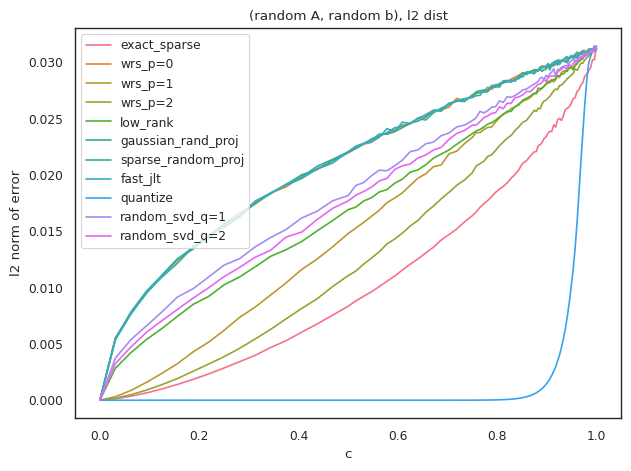

In [ ]:
for method, f in fs.items():
    # np.save(os.path.join(path, 'data/rA_rb_l2_' + method + '.npy'), l2_dists_random_Ab[method])
    l2_dists_random_Ab[method] = np.load(os.path.join(path, 'data/rA_rb_l2_' + method + '.npy'))
    sns.lineplot(x=cs, y=l2_dists_random_Ab[method], label=method)

plt.xlabel('c')
plt.ylabel('l2 norm of error')
plt.title(f'(random A, random b), l2 dist')
plt.tight_layout()
# plt.savefig(os.path.join(path, 'diagrams/rA_rb_l2.png'), dpi=300)


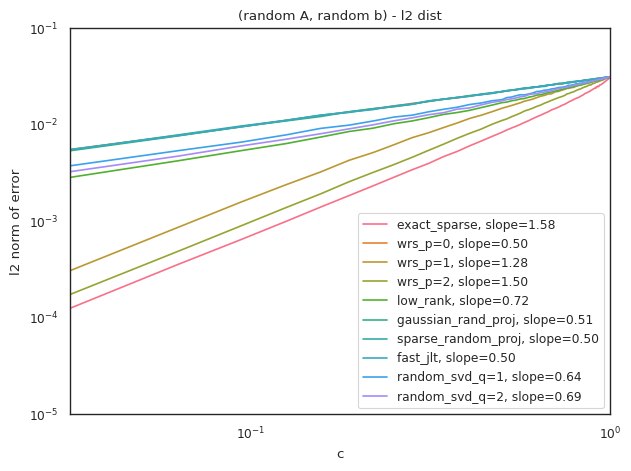

In [ ]:
for method, f in fs.items():
    if method == 'quantize':
        continue
    slope, _  = np.polyfit(np.log(cs[1:-16]), np.log(l2_dists_random_Ab[method][1:-16]), 1)
    sns.lineplot(x=cs, y=l2_dists_random_Ab[method], label=f'{method}, slope={slope:.2f}')
plt.xlabel('c')
plt.ylabel('l2 norm of error')
plt.xscale('log')
plt.yscale('log')
plt.xlim(cs[1], 1)
plt.ylim(1e-5, 1e-1)
plt.title('(random A, random b) - l2 dist')
plt.tight_layout()
plt.savefig(os.path.join(path, 'diagrams/rA_rb_l2_log.png'), dpi=300)

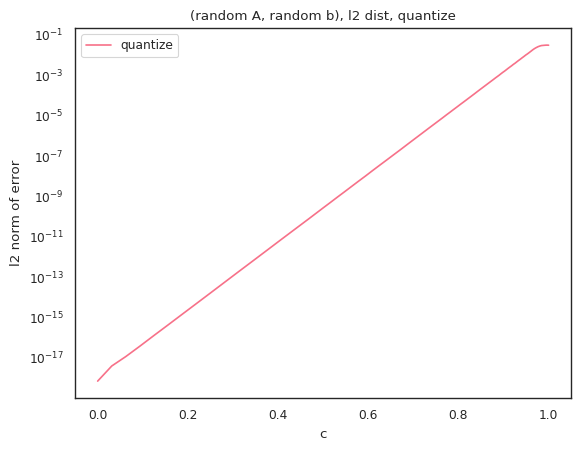

In [ ]:
sns.lineplot(x=cs, y=l2_dists_random_Ab['quantize'], label='quantize')
plt.yscale('log')
plt.xlabel('c')
plt.ylabel('l2 norm of error')
plt.title('(random A, random b), l2 dist, quantize')
plt.savefig(os.path.join(path, 'diagrams/rA_rb_l2_quantize.png'), dpi=300)

# Model

In [ ]:
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            # 3 x 32 x 32
            nn.Conv2d(3, 128, kernel_size=5, padding="same"),
            nn.ReLU(inplace=True),
            # 128 x 32 x 32
            nn.MaxPool2d(kernel_size=2),
            # 128 x 16 x 16
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            # 128 x 16 x 16
            nn.MaxPool2d(kernel_size=2),
            # 128 x 8 x 8
            nn.Conv2d(128, 192, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            # 192 x 8 x 8
            nn.Conv2d(192, 192, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            # 192 x 8 x 8
            nn.Conv2d(192, 128, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            # 128 x 8 x 8
            nn.MaxPool2d(kernel_size=2),
            # 128 x 4 x 4
            nn.Flatten(),
            # 2048
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            # 1024
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            # 256
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        logits = self.features(x)
        probs = F.softmax(logits, dim=1)
        return logits

In [ ]:
# width = 1024
# height = 512

NUM_CLASSES = 10
model = AlexNet(NUM_CLASSES)
model.load_state_dict(torch.load('/content/drive/Othercomputers/daniel_mac/Desktop/MIT/ml_approx/modelweights'))
# model = model.double()
model = model.to(device)

In [ ]:
# # CIFAR100
# NUM_CLASSES = 100
# model = AlexNet(NUM_CLASSES)
# model = model.to(device)

In [ ]:
train_dataset = datasets.CIFAR10(
    root='/content/drive/MyDrive/ML Approximation/CIFAR10',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
    ]),
)
test_dataset = datasets.CIFAR10(
    root='/content/drive/MyDrive/ML Approximation/CIFAR10',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)
# train_dataset = datasets.MNIST(
#     root='/content/drive/MyDrive/ML Approximation/MNIST',
#     train=True,
#     download=False,
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((32, 32)),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1))
#     ]),
# )
# test_dataset = datasets.MNIST(
#     root='/content/drive/MyDrive/ML Approximation/MNIST',
#     train=False,
#     download=False,
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((32, 32)),
#         transforms.Lambda(lambda x: x.repeat(3, 1, 1))
#     ]),
# )
# train_dataset = datasets.CIFAR100(
#     root='/content/drive/MyDrive/ML Approximation/CIFAR100',
#     train=True,
#     download=False,
#     transform=transforms.ToTensor(),
# )
# test_dataset = datasets.CIFAR100(
#     root='/content/drive/MyDrive/ML Approximation/CIFAR100',
#     train=False,
#     download=False,
#     transform=transforms.ToTensor(),
# )
small_test_dataset = Subset(test_dataset, np.random.randint(10000, size=3072))

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    num_workers=2,
    shuffle=True,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    num_workers=2,
    shuffle=False,
)
small_test_loader = DataLoader(
    dataset=small_test_dataset,
    batch_size=128,
    num_workers=2,
    shuffle=False,
)

In [ ]:
model.eval()
correct = 0
total = 0
for x, y in tqdm(test_loader):
    x = x.to(device)
    # x = x.to(torch.float64)
    y = y.to(device)
    pred = model(x)
    total += len(y)
    correct += torch.sum(pred.argmax(1) == y)

correct / total

100%|██████████| 79/79 [00:01<00:00, 70.54it/s]


tensor(0.8053, device='cuda:0')

In [ ]:
num_epochs = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# model.train()
# for epoch in range(1, num_epochs + 1):
#     print(f'epoch: {epoch}')

#     # train
#     model.train()
#     for x, y in tqdm(train_loader):
#         x = x.to(device)
#         y = y.to(device)
#         pred = model(x)
#         loss = loss_fn(pred, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     # eval
#     model.eval()
#     correct = 0
#     total = 0
#     for x, y in tqdm(test_loader):
#         x = x.to(device)
#         y = y.to(device)
#         pred = model(x)
#         total += len(y)
#         correct += torch.sum(pred.argmax(1) == y)
#     print(f'test accuracy: {float(correct / total)}')

In [ ]:
from copy import deepcopy

model_approx = deepcopy(model)
weight = model.features[21].weight.data.cpu().numpy()

### (actual A, actual b)

In [ ]:
def actual_Ab_l2_dists(f):
    l2_dists = []
    model.eval()
    model_approx.eval()
    for c in tqdm(cs):
        weight_approx = f(weight, c)
        model_approx.features[21].weight.data = torch.from_numpy(weight_approx).to(device)
        l2_dist = 0
        for x, _ in test_loader:
            x = x.to(device)
            # x = x.to(torch.float64)
            b = model.features[:21](x)
            Ab = model.features[21](b)
            fAb = model_approx.features[21](b)
            l2_dist += torch.sum(torch.norm(Ab - fAb, dim=1) / torch.norm(b, dim=1))
        l2_dist /= len(test_dataset) * norm(weight)
        l2_dists.append(l2_dist.item())
    return l2_dists


def actual_Ab_accs(f):
    accs = []
    model.eval()
    model_approx.eval()
    for c in tqdm(cs):
        weight_approx = f(weight, c)
        model_approx.features[21].weight.data = torch.from_numpy(weight_approx).to(device)
        total = 0
        correct = 0
        for x, y in test_loader:
            x = x.to(device)
            # x = x.to(torch.float64)
            y = y.to(device)
            pred = model_approx(x)
            total += len(y)
            correct += torch.sum(pred.argmax(1) == y)
        accs.append((correct / total).item())
    return accs


def actual_Ab_loss(f):
    losses = []
    model.eval()
    model_approx.eval()
    for c in tqdm(cs):
        weight_approx = f(weight, c)
        model_approx.features[21].weight.data = torch.from_numpy(weight_approx).to(device)
        total = 0
        loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # x = x.to(torch.float64)
            y = y.to(device)
            pred = model_approx(x)
            total += len(y)
            loss += len(y) * loss_fn(pred, y)
        losses.append(loss.item() / total)
    return losses

In [ ]:
l2_dists_actual_Ab = {}
accs_actual_Ab = {}
losses_actual_Ab = {}

In [ ]:
for method, f in fs.items():
    if method == 'quantize':
        continue
    l2_dists_actual_Ab[method] = actual_Ab_l2_dists(f)

100%|██████████| 81/81 [01:10<00:00,  1.15it/s]


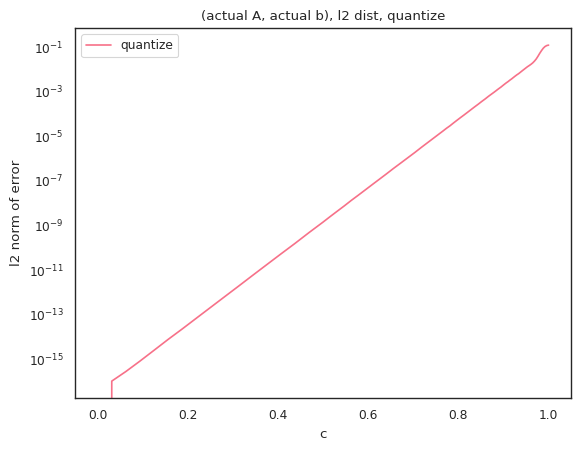

In [ ]:
# run individually with model.double()
# l2_dists_actual_Ab['quantize'] = actual_Ab_l2_dists(quantize)
# plt.plot(cs, l2_dists_actual_Ab['quantize'], label='quantize')
sns.lineplot(x=cs, y=l2_dists_actual_Ab['quantize'], label='quantize')
plt.yscale('log')
plt.xlabel('c')
plt.ylabel('l2 norm of error')
plt.title('(actual A, actual b), l2 dist, quantize')
plt.savefig(os.path.join(path, 'diagrams/aA_ab_l2_quantize.png'), dpi=300)

100%|██████████| 81/81 [01:17<00:00,  1.05it/s]


<Axes: >

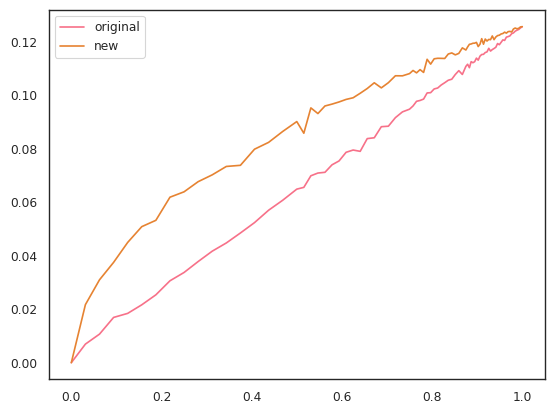

In [ ]:
def original(A, c):
    if c == 1:
        return np.zeros_like(A)
    d = math.floor(A.shape[1] * (1 - c))
    srp = SparseRandomProjection(n_components=d, density=1/3, compute_inverse_components=True)
    srp.fit(A)
    return A @ srp.inverse_components_ @ srp.components_

sns.lineplot(x=cs, y=actual_Ab_l2_dists(original), label='original')
sns.lineplot(x=cs, y=actual_Ab_l2_dists(sparse_random_projection), label='new')

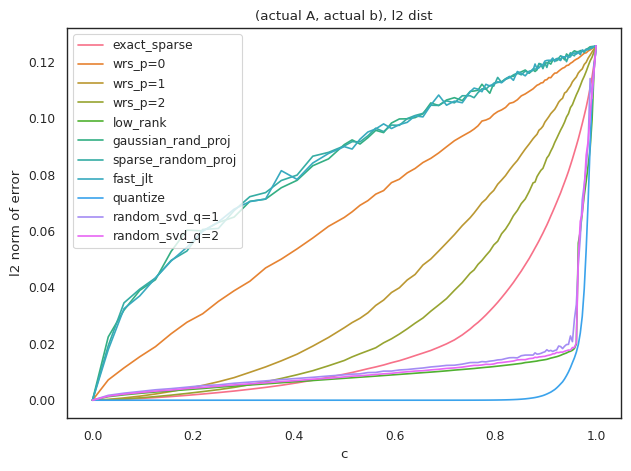

In [ ]:
for method, f in fs.items():
    np.save(os.path.join(path, 'data/aA_ab_l2_' + method + '.npy'), l2_dists_actual_Ab[method])
    l2_dists_actual_Ab[method] = np.load(os.path.join(path, 'data/aA_ab_l2_' + method + '.npy'))
    sns.lineplot(x=cs, y=l2_dists_actual_Ab[method], label=method)
plt.xlabel('c')
plt.ylabel('l2 norm of error')
plt.title(f'(actual A, actual b), l2 dist')
plt.tight_layout()
plt.savefig(os.path.join(path, 'diagrams/aA_ab_l2.png'), dpi=300)

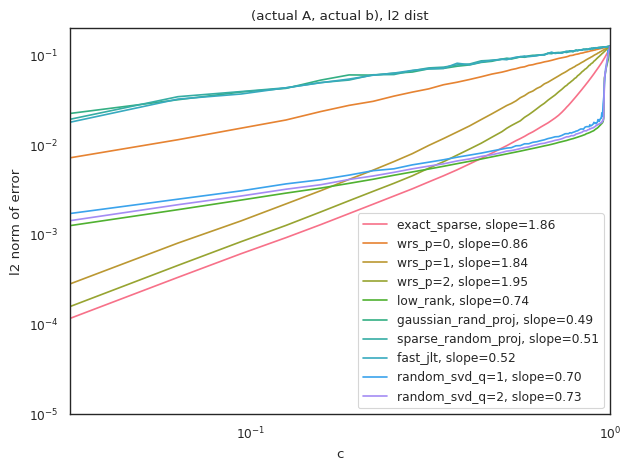

In [ ]:
for method, f in fs.items():
    if method == 'quantize':
        continue
    slope, _  = np.polyfit(np.log(cs[1:-32]), np.log(l2_dists_actual_Ab[method][1:-32]), 1)
    sns.lineplot(x=cs, y=l2_dists_actual_Ab[method], label=f'{method}, slope={slope:.2f}')
plt.xlabel('c')
plt.ylabel('l2 norm of error')
plt.xscale('log')
plt.yscale('log')
plt.xlim(cs[1], 1)
plt.ylim(1e-5, 2e-1)
plt.title('(actual A, actual b), l2 dist')
plt.tight_layout()
plt.savefig(os.path.join(path, 'diagrams/aA_ab_l2_log.png'), dpi=300)

In [ ]:
# plt.plot(cs, actual_Ab_l2_dists(quantize))
# plt.yscale('log')
# plt.xlabel('c')
# plt.ylabel('l2 norm of error')
# plt.title('(actual A, actual b), log L2 dist, quantize')
# plt.savefig('./drive/MyDrive/ML Approximation/l2/actual_A_actual_b_quantize_log.png')

In [ ]:
# wrs_actual_Ab = {}
# for method, f in {
#     'random_p=2': lambda A, c: weighted_random_sparsify(A, c, 2),
#     'random_p=4': lambda A, c: weighted_random_sparsify(A, c, 4),
#     'random_p=8': lambda A, c: weighted_random_sparsify(A, c, 8),
#     'random_p=16': lambda A, c: weighted_random_sparsify(A, c, 16),
# }.items():
#     wrs_actual_Ab[method] = tmp(f)
#     plt.plot(cs, wrs_actual_Ab[method], label=method)

# plt.xlabel('c')
# plt.ylabel('l2 norm of error')
# plt.title(f'(actual A, actual b), L2 dist')
# plt.legend(loc='upper right')
# plt.savefig(f'./drive/MyDrive/ML Approximation/l2/actual_A_actual_b_2048x1024_wrs.png')

In [ ]:
def effective_rank(A, energy_threshold=0.99):
    singular_values = np.linalg.svd(A, compute_uv=False)
    total_energy = np.sum(singular_values**2)
    retained_energy = np.cumsum(singular_values**2) / total_energy
    return np.searchsorted(retained_energy, energy_threshold) + 1

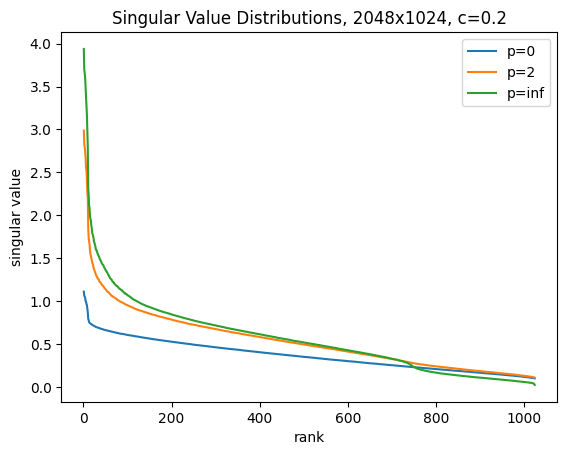

In [ ]:
plt.plot(np.arange(1, 1025), np.linalg.svd(weighted_random_sparsify(weight, 0.2, 0), compute_uv=False), label='p=0')
plt.plot(np.arange(1, 1025), np.linalg.svd(weighted_random_sparsify(weight, 0.2, 2), compute_uv=False), label='p=2')
plt.plot(np.arange(1, 1025), np.linalg.svd(exact_sparsify(weight, 0.2), compute_uv=False), label='p=inf')
plt.legend()
plt.xlabel('rank')
plt.ylabel('singular value')
plt.title('Singular Value Distributions, 2048x1024, c=0.2')
plt.savefig('./drive/MyDrive/ML Approximation/l2/singular_value_distributions_2048x1024_c=0.2.png')

In [ ]:
accs_actual_Ab['quantize'] = actual_Ab_accs(quantize)

100%|██████████| 81/81 [01:09<00:00,  1.17it/s]


In [ ]:
for method, f in fs.items():
    accs_actual_Ab[method] = actual_Ab_accs(f)

100%|██████████| 81/81 [01:09<00:00,  1.16it/s]


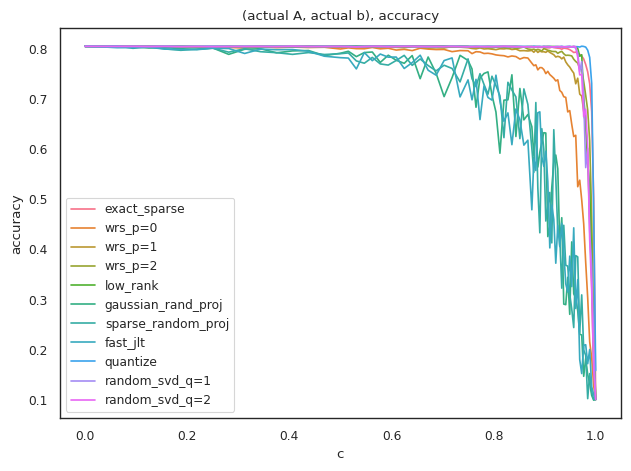

In [ ]:
for method, f in fs.items():
    np.save(os.path.join(path, 'data/aA_ab_acc_' + method + '.npy'), accs_actual_Ab[method])
    accs_actual_Ab[method] = np.load(os.path.join(path, 'data/aA_ab_acc_' + method + '.npy'))
    sns.lineplot(x=cs, y=accs_actual_Ab[method], label=method)
plt.xlabel('c')
plt.ylabel('accuracy')
plt.title(f'(actual A, actual b), accuracy')
plt.tight_layout()
plt.savefig(os.path.join(path, 'diagrams/aA_ab_acc.png'), dpi=300)

In [ ]:
# cs = np.linspace(0, 1, 33)

# for method, f in (
#     ('unif_sparse', lambda A, c: weighted_random_sparsify(A, c, 0)),
#     ('sparse_rand_proj', sparse_random_projection)
# ):
#     accs_actual_Ab[method] = sum((actual_Ab_accs(f) for _ in range(4)), np.zeros(33)) / 4
#     plt.plot(cs, accs_actual_Ab[method], label=method)

# plt.xlabel('c')
# plt.ylabel('accuracy')
# plt.title(f'(actual A, actual b), accuracy, model 2')
# plt.legend(loc='lower left')
# plt.savefig(f'./drive/MyDrive/ML Approximation/accuracy/actual_A_actual_b_unif_vs_proj_model_2.png')

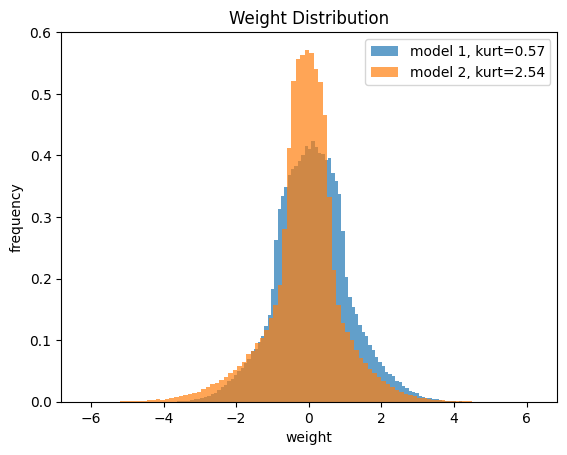

In [ ]:
from scipy.stats import kurtosis

# weight_1 = weight.flatten()
# weight_2 = weight.flatten()
plt.hist(weight_1 / weight_1.std(), bins=100, density=True, alpha=0.7, label=f'model 1, kurt={kurtosis(weight_1):.2f}')
plt.hist(weight_2 / weight_2.std(), bins=100, density=True, alpha=0.7, label=f'model 2, kurt={kurtosis(weight_2):.2f}')
plt.legend()
plt.xlabel('weight')
plt.ylabel('frequency')
plt.title('Weight Distribution')
plt.savefig('./drive/MyDrive/ML Approximation/l2/weight_distribution_model_1_vs_model_2.png')

In [ ]:
# for method, f in fs.items():
#     plt.plot(np.log(cs), np.log(accs_actual_Ab[method]), label=method)
# plt.xlabel('c')
# plt.ylabel('accuracy')
# plt.title(f'(actual A, actual b), accuracy, w={width}')
# plt.legend(loc='upper right')
# plt.savefig(f'./drive/MyDrive/ML Approximation/accuracy/actual_A_actual_b_log_w={width}.png')

In [ ]:
for method, f in fs.items():
    losses_actual_Ab[method] = actual_Ab_loss(f)

100%|██████████| 81/81 [01:11<00:00,  1.13it/s]


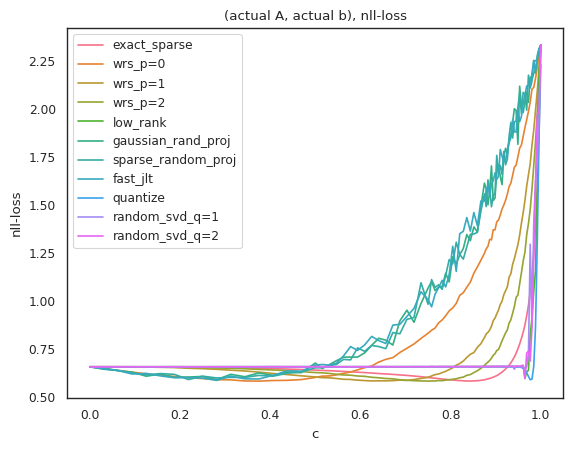

In [ ]:
for method, f in fs.items():
    np.save(os.path.join(path, 'data/aA_ab_loss_' + method + '.npy'), losses_actual_Ab[method])
    losses_actual_Ab[method] = np.load(os.path.join(path, 'data/aA_ab_loss_' + method + '.npy'))
    sns.lineplot(x=cs, y=losses_actual_Ab[method], label=method)
plt.xlabel('c')
plt.ylabel('nll-loss')
plt.title(f'(actual A, actual b), nll-loss')
plt.savefig(os.path.join(path, 'diagrams/aA_ab_loss.png'), dpi=300)

In [ ]:
# for method, f in fs.items():
#     plt.plot(np.log(cs), np.log(loss_actual_Ab[method]), label=method)
# plt.xlabel('c')
# plt.ylabel('loss')
# plt.title(f'(actual A, actual b), NLL Loss, w={width}')
# plt.legend(loc='upper right')
# plt.savefig(f'./drive/MyDrive/ML Approximation/loss/actual_A_actual_b_log_w={width}.png')

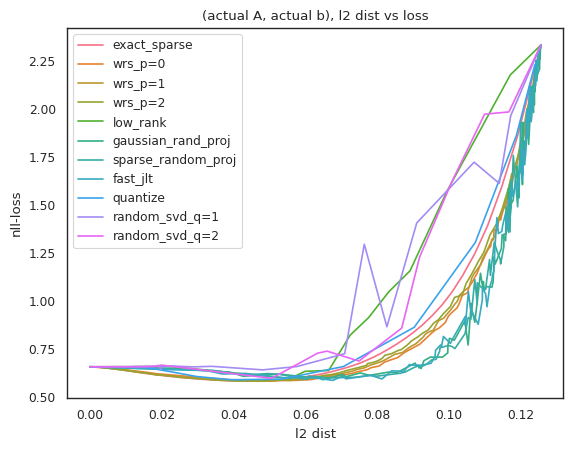

In [ ]:
for method, f in fs.items():
    sns.lineplot(x=l2_dists_actual_Ab[method], y=losses_actual_Ab[method], label=method)
plt.xlabel('l2 dist')
plt.ylabel('nll-loss')
plt.title(f'(actual A, actual b), l2 dist vs loss')
plt.savefig(os.path.join(path, 'diagrams/aA_ab_l2_vs_loss.png'), dpi=300)

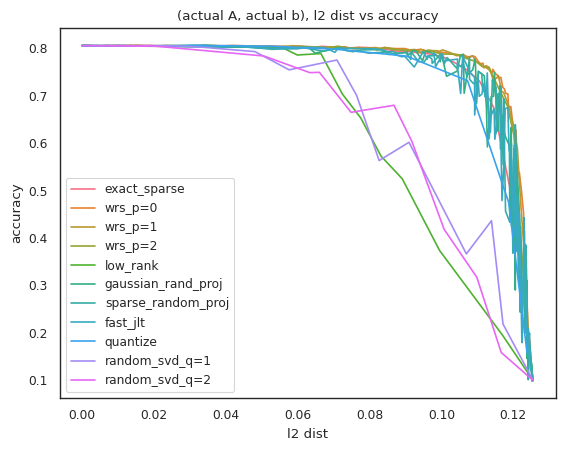

In [ ]:
for method, f in fs.items():
    sns.lineplot(x=l2_dists_actual_Ab[method], y=accs_actual_Ab[method], label=method)

plt.xlabel('l2 dist')
plt.ylabel('accuracy')
plt.title(f'(actual A, actual b), l2 dist vs accuracy')
plt.savefig(os.path.join(path, 'diagrams/aA_ab_l2_vs_acc.png'), dpi=300)

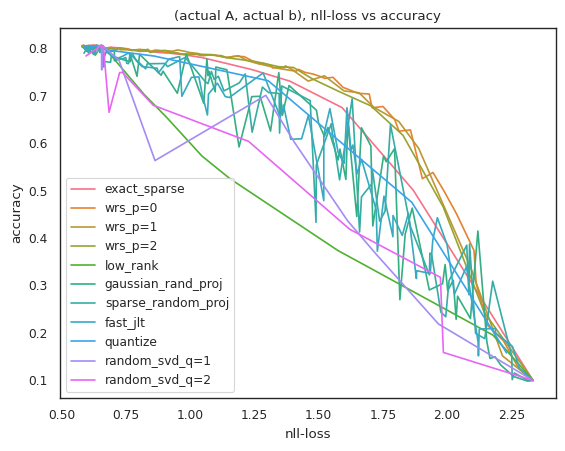

In [ ]:
for method, f in fs.items():
    sns.lineplot(x=losses_actual_Ab[method], y=accs_actual_Ab[method], label=method)

plt.xlabel('nll-loss')
plt.ylabel('accuracy')
plt.title(f'(actual A, actual b), nll-loss vs accuracy')
plt.savefig(os.path.join(path, 'diagrams/aA_ab_loss_vs_acc.png'), dpi=300)

# Entry & Singular Value Distributions

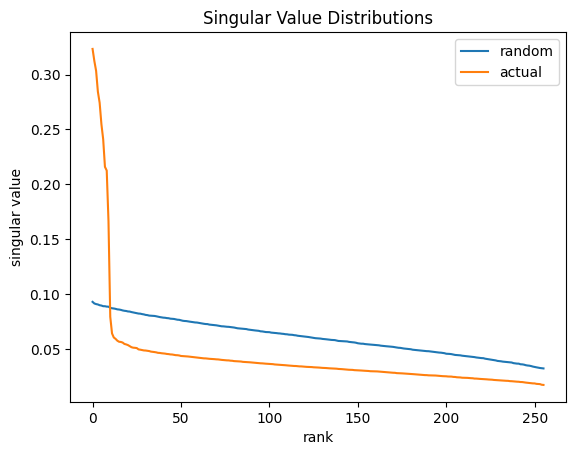

In [ ]:
_, S_random, _ = np.linalg.svd(A, full_matrices=False)
_, S_actual, _ = np.linalg.svd(weight, full_matrices=False)
plt.plot(range(len(S_random)), S_random / norm(A), label='random')
plt.plot(range(len(S_actual)), S_actual / norm(weight), label='actual')
plt.legend()
plt.xlabel('rank')
plt.ylabel('singular value')
plt.title('Singular Value Distributions')
plt.savefig('./drive/MyDrive/ML Approximation/l2/singular_value_distributions.png')

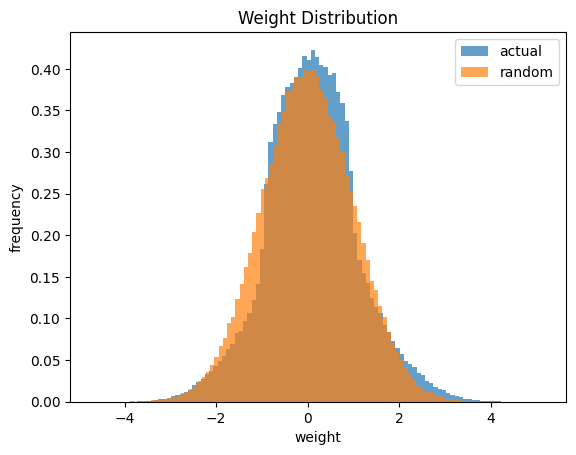

In [ ]:
plt.hist(weight.flatten() / weight.std(), bins=100, density=True, label='actual', alpha=0.7)
plt.hist(A.flatten() / A.std(), bins=100, density=True, label='random', alpha=0.7)
plt.legend()
plt.xlabel('weight')
plt.ylabel('frequency')
plt.title('Weight Distribution')
plt.savefig('./drive/MyDrive/ML Approximation/l2/weight_distribution.png')